In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.stats as stats
import sys
sys.path.append('/Users/wastechs/Documents/git-repos/energy-efficiency')
from lib.util.helper import query_table, weekday_time_series
from validation.gp.create_train_inference import create_train_inference_gp
from lib.util import helper, data_preprocessing
import torch
from torch.utils.data import TensorDataset, DataLoader
import gpytorch
import seaborn as sns
import plotly.express as px
import plotly
import plotly.graph_objects as go
import torch
import gpytorch
%matplotlib widget

In [ ]:
df = query_table(table='vacuum_pump_1_30T')

In [ ]:
df['kw'] = round(df['kw'], 2)
df['kw'] = df['kw'].apply(lambda x: 0.0 if x == -0.0 else x)

In [ ]:
px.line(
    x=df.index, y=df.kw, 
    title='Vacuum Pump 1',
    labels={
        'x': 'Time',
        'y': 'kW'
    },
    markers=False)

### 1hr—predict the next 5 days

In [ ]:
df = df[df.index < '2017-12-09']

print(df.shape)

time_int_range = np.arange(0, 1656*60, 60)
df['t'] = time_int_range
df['t'] = (df['t'] - df['t'].min()) / (df['t'].max() - df['t'].min())

training = df[df.index < '2017-12-04']
testing = df[df.index >= '2017-12-04']

X_train = torch.from_numpy(training['t'].values).to(torch.double)
y_train = torch.from_numpy(training['kw'].values).to(torch.double)

X_test = torch.from_numpy(df['t'].values).to(torch.double)
X_test_sub = torch.from_numpy(testing['t'].values).to(torch.double)
y_test = torch.from_numpy(testing['kw'].values).to(torch.double)

#X = df['t'].values
#y = df['kw'].values
#n = len(X)
#prop_train = 0.8
#n_train = round(prop_train * n)

# Training
#X_train = torch.from_numpy(X[:n_train]).to(torch.float64)
#y_train = torch.from_numpy(y[:n_train]).to(torch.float64)

# Testing
#X_test = torch.from_numpy(y[n_train:]).to(torch.float64)
#X_test = torch.from_numpy(X).to(torch.float64)
#y_test = torch.from_numpy(y[n_train:]).to(torch.float64)

# Standardizing helps with hyperparameter initialization
y_train_mean = torch.mean(y_train)
y_train_std = torch.std(y_train)

y_train = (y_train - y_train_mean) / (y_train_std)
y_test = (y_test - y_train_mean) / (y_train_std)

#lt.figure(figsize=(16, 6))
#plt.plot(X_train.numpy(), y_train.numpy())
#plt.plot(X_test.numpy(), y_test.numpy())

In [ ]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32)

test_dataset = TensorDataset(X_test_sub, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype

In [ ]:
## v1 - end loss = 1.09 ##

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        period_constraint_short = gpytorch.constraints.Interval(0.0048, 0.0096) ## short term 1

        seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_short
                )
            )

        period_constraint_short_2 = gpytorch.constraints.Interval(0.0120, 0.0169) ## short term 2

        seasonal_periodic_short_2 = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_short_2
                )
            )

        period_constraint_long = gpytorch.constraints.Interval(0.0966, 0.1027) ## long term 1

        seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_long
                )
            )

        ## Local Variations ##
        local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

        local_variation = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RQKernel()
            )
            
        local_variation.alpha = 1


        #self.covar_module = seasonal_periodic_short + seasonal_periodic_short_2 + \
        #    seasonal_periodic_long + local_variation

        self.covar_module = seasonal_periodic_short_2 + seasonal_periodic_long
            
        self.mean_module = gpytorch.means.ZeroMean()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

In [ ]:
## v2 - half day, day, and weekly periodic kernels - start loss = 1.21 ##

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        period_constraint_short = gpytorch.constraints.Interval(0.0048, 0.0096) ## 12hr periodicity

        half_day_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_short
                )
            )

        period_constraint_short_2 = gpytorch.constraints.Interval(0.0120, 0.0169) ## 24hr periodicity

        day_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_short_2
                )
            )

        period_constraint_long = gpytorch.constraints.Interval(0.0966, 0.1027) ## ~170hr (weekly) periodicity

        weekly_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_long
                )
            )

        ## Local Variations ##
        local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)
        
        local_variation = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RQKernel()
            )
            
        local_variation.alpha = 1


        self.covar_module = half_day_kernel + day_kernel + weekly_kernel
            
        self.mean_module = gpytorch.means.ZeroMean()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

In [ ]:
## v3 - 3 quasi-periodic kernels - end loss = 0.71 ##

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        period_constraint_short = gpytorch.constraints.Interval(0.0048, 0.0096) ## 12hr periodicity

        half_day_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_short
                )
            )

        half_day_variation_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

        quasi_half_day_kernel = half_day_kernel * half_day_variation_kernel

        period_constraint_short_2 = gpytorch.constraints.Interval(0.0120, 0.0169) ## 24hr periodicity

        day_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_short_2
                )
            )
        
        day_variation_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

        quasi_day_kernel = day_kernel * day_variation_kernel

        period_constraint_long = gpytorch.constraints.Interval(0.0966, 0.1027) ## ~170hr (weekly) periodicity

        weekly_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_long
                )
            )

        weekly_variation_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

        quasi_weekly_kernel = weekly_kernel * weekly_variation_kernel

        ## Local Variations ##
        local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)
        
        local_variation = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RQKernel()
            )
            
        local_variation.alpha = 1


        self.covar_module = quasi_half_day_kernel + quasi_day_kernel + quasi_weekly_kernel
            
        self.mean_module = gpytorch.means.ZeroMean()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

In [ ]:
## v4 - 3 quasi-periodic kernels with non-periodic trends - end loss = 0.69 ##

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        period_constraint_short = gpytorch.constraints.Interval(0.0048, 0.0096) ## 12hr periodicity

        half_day_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_short
                )
            )

        half_day_variation_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

        quasi_half_day_kernel = half_day_kernel * half_day_variation_kernel

        period_constraint_short_2 = gpytorch.constraints.Interval(0.0120, 0.0169) ## 24hr periodicity

        day_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_short_2
                )
            )
        
        day_variation_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

        quasi_day_kernel = day_kernel * day_variation_kernel

        period_constraint_long = gpytorch.constraints.Interval(0.0966, 0.1027) ## ~170hr (weekly) periodicity

        weekly_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_long
                )
            )

        weekly_variation_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

        quasi_weekly_kernel = weekly_kernel * weekly_variation_kernel

        ## Local Variations ##
        local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)
        
        local_variation = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RQKernel()
            )
            
        #local_variation.alpha = 1


        self.covar_module = quasi_half_day_kernel + quasi_day_kernel + quasi_weekly_kernel + local_variation
            
        self.mean_module = gpytorch.means.ZeroMean()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

In [ ]:
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 75

model.double()
likelihood.double()

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood=likelihood, model=model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, y_train)
    loss.backward()

    print('Iter {} , Loss = {} , Noise = {}'.format(
        i+1, loss, model.likelihood.noise.item() 
    ))

    optimizer.step()

model.eval()
likelihood.eval()

In [ ]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_preds = likelihood(model(X_test))

    #test_preds = observed_preds.mean[n_train:]
    #mse = mean_squared_error(y_test.numpy(), test_preds.numpy())
    #mape = mean_absolute_percentage_error(y_test.numpy(), test_preds.numpy())

    f, ax = plt.subplots(figsize=(12, 6))
    lower, upper = observed_preds.confidence_region()
    ax.plot(X_train.numpy(), y_train.numpy())
    ax.plot(X_test.numpy(), observed_preds.mean.numpy())
    ax.plot(X_test_sub.numpy(), y_test.numpy(), color='red')
    ax.fill_between(X_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, color='#2ecc71')
    #plt.axvline(x=955, linestyle='--', color='black', lw=1)
    ax.legend(['Observed Data', 'Predictions', 'Test Data', 'Uncertainty'])
    plt.xlabel('Time Step')
    plt.ylabel('Standardized kW')
    #plt.title('Gaussian Process Regression: Interpolation and Extrapolation of "EG" \n  MSE = {} \n MAPE = {}'.
    #format(round(mse, 2), round(mape, 2)))
    plt.show()

### Experiment Notes:

**Periodic Kernel**:

Just a sum of periodic kernels captures the periodicity of the signal. Typically, the ampltitude of the signal is NOT captured by the learned periodic parameter (outputscale)

In [ ]:
#df = df[df.index < '2017-12-09']
df = df[(df.index >= '2017-11-05') & (df.index < '2017-12-09')]

print(df.shape)

time_int_range = np.arange(0, df.shape[0]*30, 30)
df['t'] = time_int_range
df['t'] = (df['t'] - df['t'].min()) / (df['t'].max() - df['t'].min())

training = df[df.index < '2017-12-08']
testing = df[df.index >= '2017-12-08']

X_train = torch.from_numpy(training['t'].values).to(torch.float32)
y_train = torch.from_numpy(training['kw'].values).to(torch.float32)

X_test = torch.from_numpy(df['t'].values).to(torch.float32)
X_test_sub = torch.from_numpy(testing['t'].values).to(torch.float32)
y_test = torch.from_numpy(testing['kw'].values).to(torch.float32)

# Standardizing helps with hyperparameter initialization
y_train_mean = torch.mean(y_train)
y_train_std = torch.std(y_train)

y_train = (y_train - y_train_mean) / (y_train_std)
y_test = (y_test - y_train_mean) / (y_train_std)

In [ ]:
## v1 - end loss = 0.71##

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        period_constraint_short = gpytorch.constraints.Interval(0.06, 0.09) ## 12hr periodicity

        half_day_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_short
                )
            )

        half_day_variation_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

        quasi_half_day_kernel = half_day_kernel * half_day_variation_kernel

        period_constraint_short_2 = gpytorch.constraints.Interval(0.025, 0.03) ## 48hr periodicity

        day_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_short_2
                )
            )
        
        day_variation_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

        quasi_day_kernel = day_kernel * day_variation_kernel


        period_constraint_long = gpytorch.constraints.Interval(0.05, 0.06) ## ~96hr (weekly) periodicity

        weekly_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_long
                )
            )

        weekly_variation_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

        quasi_weekly_kernel = weekly_kernel * weekly_variation_kernel


        ## Local Variations ##
        local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)
        
        local_variation = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
            )
            
        #local_variation.alpha = 1

        self.covar_module = quasi_day_kernel + quasi_weekly_kernel
        self.mean_module = gpytorch.means.ZeroMean()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

In [ ]:
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100

#model.double()
#likelihood.double()

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood=likelihood, model=model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, y_train)
    loss.backward()

    print('Iter {} , Loss = {} , Noise = {}'.format(
        i+1, loss, model.likelihood.noise.item() 
    ))

    optimizer.step()

model.eval()
likelihood.eval()

In [ ]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_preds = likelihood(model(X_test))

    #test_preds = observed_preds.mean[n_train:]
    #mse = mean_squared_error(y_test.numpy(), test_preds.numpy())
    #mape = mean_absolute_percentage_error(y_test.numpy(), test_preds.numpy())

    f, ax = plt.subplots(figsize=(12, 6))
    lower, upper = observed_preds.confidence_region()
    ax.plot(X_train.numpy(), y_train.numpy())
    ax.plot(X_test.numpy(), observed_preds.mean.numpy())
    ax.plot(X_test_sub.numpy(), y_test.numpy(), color='red')
    ax.fill_between(X_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, color='#2ecc71')
    #plt.axvline(x=955, linestyle='--', color='black', lw=1)
    ax.legend(['Observed Data', 'Predictions', 'Test Data', 'Uncertainty'])
    plt.xlabel('Time Step')
    plt.ylabel('Standardized kW')
    #plt.title('Gaussian Process Regression: Interpolation and Extrapolation of "EG" \n  MSE = {} \n MAPE = {}'.
    #format(round(mse, 2), round(mape, 2)))
    plt.show()

### Train = 4 days ; Test = 1 day ; Agg = 30T

In [96]:
#df = df[df.index < '2017-12-09']
df = df[(df.index >= '2017-10-04') & (df.index < '2017-10-28')]

print(df.shape)

time_int_range = np.arange(0, df.shape[0]*30, 30)
df['t'] = time_int_range
df['t'] = (df['t'] - df['t'].min()) / (df['t'].max() - df['t'].min())

training = df[df.index < '2017-10-25']
testing = df[df.index >= '2017-10-25']

X_train = torch.from_numpy(training['t'].values).to(torch.float32)
y_train = torch.from_numpy(training['kw'].values).to(torch.float32)

X_test = torch.from_numpy(df['t'].values).to(torch.float32)
X_test_sub = torch.from_numpy(testing['t'].values).to(torch.float32)
y_test = torch.from_numpy(testing['kw'].values).to(torch.float32)

# Standardizing helps with hyperparameter initialization
y_train_mean = torch.mean(y_train)
y_train_std = torch.std(y_train)

y_train = (y_train - y_train_mean) / (y_train_std)
y_test = (y_test - y_train_mean) / (y_train_std)

(1152, 3)


In [ ]:
## v1 - end loss = 0.71##

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        period_constraint_short = gpytorch.constraints.Interval(0.16, 0.17) ## 12hr periodicity

        half_day_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_short
                )
            )

        half_day_variation_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

        quasi_half_day_kernel = half_day_kernel * half_day_variation_kernel

        period_constraint_short_2 = gpytorch.constraints.Interval(0.07, 0.09) ## 24hr periodicity

        day_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_short_2
                )
            )
        
        day_variation_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RQKernel()
        )

        quasi_day_kernel = day_kernel * day_variation_kernel


        ## Local Variations ##
        local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)
        
        local_variation = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RQKernel()
            )
            
        #local_variation.alpha = 1

        self.covar_module = quasi_half_day_kernel #+ quasi_day_kernel + local_variation
        self.mean_module = gpytorch.means.ZeroMean()


In [112]:
## v1 - end loss = 0.71##

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        period_constraint_short = gpytorch.constraints.Interval(0.014, 0.023) ## 12hr periodicity

        half_day_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_short
                )
            )

        half_day_variation_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

        quasi_half_day_kernel = half_day_kernel * half_day_variation_kernel

        period_constraint_short_2 = gpytorch.constraints.Interval(0.034, 0.046) ## 24hr periodicity

        day_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_short_2
                )
            )
        
        day_variation_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

        quasi_day_kernel = day_kernel * day_variation_kernel


        ## Local Variations ##
        local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)
        
        local_variation = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RQKernel()
            )
            
        #local_variation.alpha = 1

        #self.covar_module = quasi_half_day_kernel #+ quasi_day_kernel + local_variation
        self.covar_module =local_variation
        self.mean_module = gpytorch.means.ZeroMean()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

In [110]:
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 150

#model.double()
#likelihood.double()

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood=likelihood, model=model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, y_train)
    loss.backward()

    print('Iter {} , Loss = {} , Noise = {}'.format(
        i+1, loss, model.likelihood.noise.item() 
    ))

    optimizer.step()

model.eval()
likelihood.eval()

Iter 1 , Loss = 1.459570288658142 , Noise = 0.6932471990585327
Iter 2 , Loss = 1.4449223279953003 , Noise = 0.7444967031478882
Iter 3 , Loss = 1.4339756965637207 , Noise = 0.7972709536552429
Iter 4 , Loss = 1.4231265783309937 , Noise = 0.8504939079284668
Iter 5 , Loss = 1.4244831800460815 , Noise = 0.9027290940284729
Iter 6 , Loss = 1.419446587562561 , Noise = 0.9524487257003784
Iter 7 , Loss = 1.4159550666809082 , Noise = 0.9979524612426758
Iter 8 , Loss = 1.4169566631317139 , Noise = 1.037756323814392
Iter 9 , Loss = 1.415173053741455 , Noise = 1.0707080364227295
Iter 10 , Loss = 1.4172980785369873 , Noise = 1.0961391925811768
Iter 11 , Loss = 1.415604591369629 , Noise = 1.1139039993286133
Iter 12 , Loss = 1.4189767837524414 , Noise = 1.1242296695709229
Iter 13 , Loss = 1.425426959991455 , Noise = 1.1276911497116089
Iter 14 , Loss = 1.4177615642547607 , Noise = 1.1250759363174438
Iter 15 , Loss = 1.418538212776184 , Noise = 1.1170108318328857
Iter 16 , Loss = 1.4177498817443848 , Noi

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

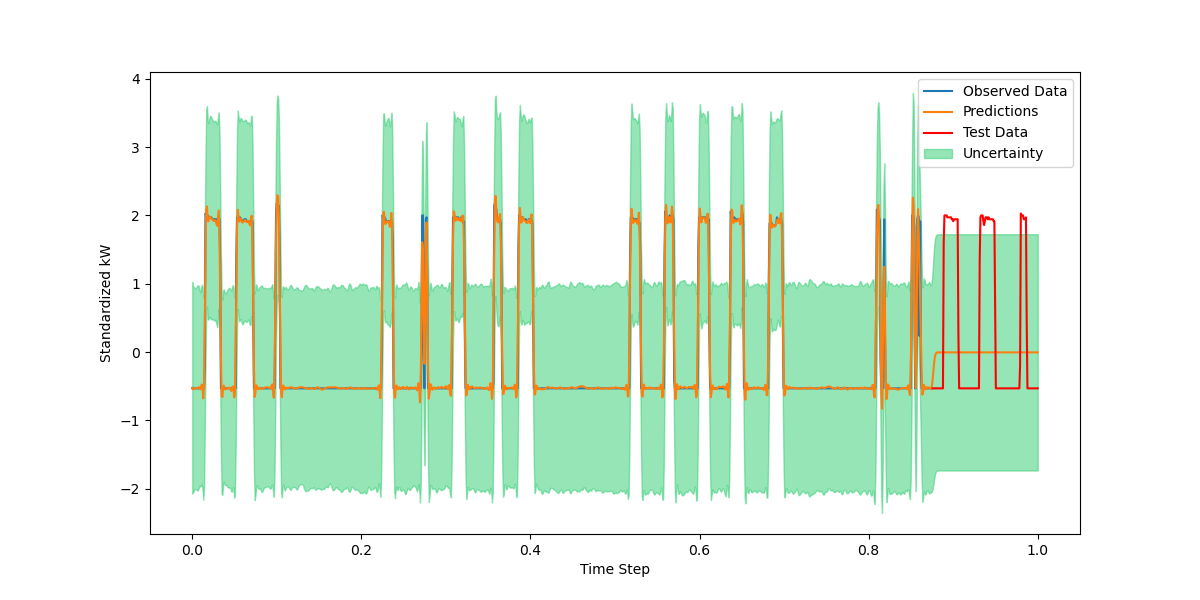

In [111]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_preds = likelihood(model(X_test))

    #test_preds = observed_preds.mean[n_train:]
    #mse = mean_squared_error(y_test.numpy(), test_preds.numpy())
    #mape = mean_absolute_percentage_error(y_test.numpy(), test_preds.numpy())

    f, ax = plt.subplots(figsize=(12, 6))
    lower, upper = observed_preds.confidence_region()
    ax.plot(X_train.numpy(), y_train.numpy())
    ax.plot(X_test.numpy(), observed_preds.mean.numpy())
    ax.plot(X_test_sub.numpy(), y_test.numpy(), color='red')
    ax.fill_between(X_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, color='#2ecc71')
    #plt.axvline(x=955, linestyle='--', color='black', lw=1)
    ax.legend(['Observed Data', 'Predictions', 'Test Data', 'Uncertainty'])
    plt.xlabel('Time Step')
    plt.ylabel('Standardized kW')
    #plt.title('Gaussian Process Regression: Interpolation and Extrapolation of "EG" \n  MSE = {} \n MAPE = {}'.
    #format(round(mse, 2), round(mape, 2)))
    plt.show()

In [ ]:
model.state_dict()

In [ ]:
model.covar_module.kernels[0]

In [ ]:
for module in model.covar_module.kernels:
    print(module.outputscale.item())

In [ ]:
for param_name, param in model.covar_module.kernels.named_parameters():
    print(f'Parameter name: {param_name:42} = {param.item()}')

In [ ]:
# Quasi-periodic
#print(model.covar_module.kernels[0].outputscale)
print(model.covar_module.kernels[0].lengthscale)

In [ ]:
# RQ
print(model.covar_module.kernels[1].outputscale)
print(model.covar_module.kernels[1].lengthscale)

In [ ]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

In [ ]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')